In [2]:
import ee
service_account = 'renosterveld-ee@ee-vegetation-gee4geo.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'ee-vegetation-gee4geo-6309a79ef209.json')
ee.Initialize(credentials)

In [27]:
import tensorflow as tf
import random
import json
from eoflow.models import TransformerEncoder, TempCNNModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from utils.tf_data_utils import *
from utils.globals import *

from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras import backend as K
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

random.seed(1234)

In [28]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus

In [29]:
with open('data/max.json') as f:
  Max = json.load(f)
with open('data/min.json') as f:
  Min = json.load(f)

In [30]:
# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[tsLength], dtype=tf.float32) 
    for k in featureNames
]
# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

In [31]:
validFilePath = 'data/Valid_reno_cnn.tfrecord.gz'
ind_ = random.choices(range(1,1000),k=4)
band = 16

In [32]:
salDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, 18, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[1.0]))\
.map(lambda x: standardize(x, Min,Max))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

valdat = list(salDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())

vd=[valdat[i] for i in ind_]
#vd=valdat[0:4]
vd=np.vstack(vd)

In [33]:
salDataset = tf.data.TFRecordDataset(validFilePath, compression_type='GZIP')\
.map(lambda x: parse_tfrecord(x,featuresDict))\
.flat_map(lambda x: shift_window(x, 18, len(allbands)+1))\
.map(lambda x: reshape_ts(x, featureNames))\
.map(lambda x: labeller(x, label))\
.filter(lambda x: filter_fn(x,[1.0]))\
.map(lambda x: poplabint(x, label))\
.map(lambda x, lab: toTuple(x, lab))\
.batch(1)

valdat = list(salDataset\
.map(lambda x,lab: x)\
.as_numpy_iterator())

vd_raw=[valdat[i] for i in ind_]
#vd_raw=valdat[0:4]
vd_raw=np.vstack(vd_raw)

In [34]:
model = tf.keras.models.load_model('models/saved_cnn_model_cpu', compile=False)
#model_.predict(single)

In [35]:
inp= model.layers[0].input
outp=model.layers[0].layers[-2].output
model = tf.keras.models.Model(inp,outp)

In [36]:
# Create ScoreCAM object
score = CategoricalScore([1,1,1,1])
gradcam = GradcamPlusPlus(model,
                          model_modifier=None,
                          clone=False)

# Generate heatmap with ScoreCAM
cam = gradcam(score, vd, penultimate_layer=-1)

In [37]:
def getcam(x,idx):
    cam=x[idx]
    cam=np.repeat(cam[:,np.newaxis],18,1)
    cam=np.transpose(cam)
    return cam

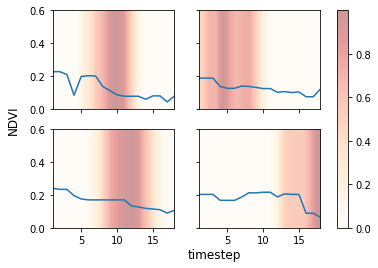

In [38]:
import matplotlib.pyplot as plt
xx = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])
nrow = 2
ncol = 2
fig, axs = plt.subplots(nrow, ncol)
for i, ax in enumerate(fig.axes):
    im= ax.imshow(getcam(cam,i), interpolation='bilinear',alpha=0.4,cmap='OrRd',extent=[1,18,0,0.6],aspect='auto')
    ax.plot(xx,vd_raw[i,...,band])

for ax in fig.get_axes():
    ax.label_outer()
fig.supxlabel("timestep")
fig.supylabel("NDVI")
fig.colorbar(im,ax=axs.ravel().tolist())

In [39]:
fig.savefig('fig_t2.png')